In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib import ticker, cm

# Bootstrap with FES

In [2]:
# Number of bootstrap samples
num_bootstrap_samples = 1000

# Specify the range of files to include
fes_files = [f"FES/fes_{i}.dat" for i in range(16, 26)]

# Load the free energy profiles from the specified files
fes_profiles = []

for file in fes_files:
    data = np.loadtxt(file)
    if len(fes_profiles) == 0:
        x_values = data[:, 0]  # the first column is the reaction coordinate
    fes_profiles.append(data[:, 1])  # the second column is the free energy

# Convert list to numpy array
fes_profiles = np.array(fes_profiles)

# Bootstrap sampling
bootstrap_means = []
for _ in range(num_bootstrap_samples):
    #generates a list of 14 indices, chosen randomly with replacement, from the range 0 to 13.
    bootstrap_sample = np.random.choice(fes_profiles.shape[0], size=fes_profiles.shape[0], replace=True)
    # fes_profiles.shape[0] gives the number of original free energy profiles

    #extracts the actual free energy profiles corresponding to the selected indices.
    bootstrap_sample_mean = np.mean(fes_profiles[bootstrap_sample, :], axis=0)
    # it computes the mean of these profiles along the reaction coordinate 
    # (i.e., average each free energy value at each reaction coordinate point across 
    # the sampled profiles).
    
    bootstrap_means.append(bootstrap_sample_mean)

# Convert bootstrap means to numpy array
bootstrap_means = np.array(bootstrap_means)

# Compute mean free energy profile and standard deviation (error bars)
mean_profile = np.mean(bootstrap_means, axis=0)
error_bars = np.std(bootstrap_means, axis=0)
#Computes the standard deviation of the bootstrap mean profiles 
# at each reaction coordinate point, providing an estimate of the error bars.


# Save the results
output_data = np.vstack((x_values, mean_profile, error_bars)).T
np.savetxt("bootstrap_fes.dat", output_data, header="Reaction Coordinate Mean_Free_Energy Error_Bars")

print("Bootstrap analysis completed. Results saved to 'bootstrap_fes.dat'.")

Bootstrap analysis completed. Results saved to 'bootstrap_fes.dat'.


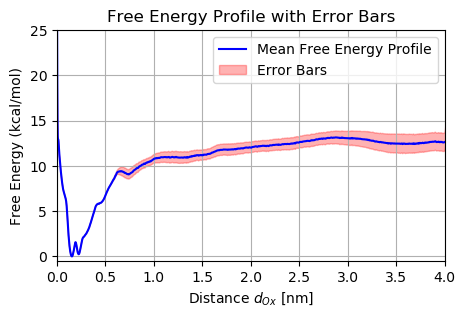

In [4]:
# Load the bootstrap results
data = np.loadtxt("bootstrap_fes.dat")
x_values = data[:, 0]
mean_profile = data[:, 1]
error_bars = data[:, 2]

plt.rcParams["figure.figsize"] = (5, 3)

# Create the plot
step = 50
#plt.errorbar(x_values[::step], mean_profile[::step]/4.184, yerr=error_bars[::step], fmt='o', color='b', ecolor='r', capsize=5, capthick=2, elinewidth=2)
#plt.plot(x_values, mean_profile/4.184, 'b')

plt.plot(x_values, mean_profile/4.184, label="Mean Free Energy Profile", color="blue")
plt.fill_between(x_values, (mean_profile - error_bars)/4.184, (mean_profile + error_bars)/4.184, 
                 color="red", alpha=0.3, label="Error Bars")

# Add labels and title
plt.xlim([0, 4])
plt.ylim([-0.5, 25])
plt.grid()
plt.xlabel(r"Distance $d_{Ox}$ [nm]")
plt.ylabel("Free Energy (kcal/mol)")
plt.title("Free Energy Profile with Error Bars")
plt.legend()

# Save the plot to a file
plt.savefig("pics/free_energy_errorbar.png")

# Funnel axis

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2191/3631413270.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  fes_rew = plumed.read_as_pandas("F_REW_FPS.dat")


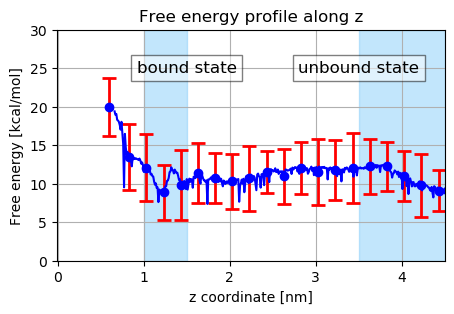

In [26]:
fes_rew = plumed.read_as_pandas("F_REW_FPS.dat")
plt.rcParams["figure.figsize"] = (5, 3)

# Generate Bootstrap Samples
# Assuming you have n data points (distances and corresponding free energies), 
# you can create N bootstrap samples

# Number of bootstrap samples
N = 1000

# Function to generate bootstrap samples
def generate_bootstrap_samples(data, N):
    n = len(data)
    bootstrap_samples = np.random.choice(data, (N, n), replace=True)
    return bootstrap_samples

finite_values= []
dist = []

for i in range(len(fes_rew["f_reweighted"])):
    if np.isfinite(fes_rew["f_reweighted"][i]):
        finite_values.append(fes_rew["f_reweighted"][i]/4.184)
        dist.append(fes_rew["z_axis.lp"][i])

bootstrap_samples = generate_bootstrap_samples(finite_values, N)

# Calculate the standard deviation of the bootstrap samples
errors = np.std(bootstrap_samples, axis=0)

step = 20
plt.rcParams["figure.figsize"] = (5, 3)
plt.errorbar(dist[::step], finite_values[::step], yerr=errors[::step], fmt='o', color='b', ecolor='r', capsize=5, capthick=2, elinewidth=2)

plt.plot(fes_rew["z_axis.lp"], fes_rew["f_reweighted"]/4.184, 'b',label="reweighting")
plt.grid()
plt.title("Free energy profile along z")
plt.xlabel("z coordinate [nm]")
plt.ylabel("Free energy [kcal/mol]")
plt.axvspan(1, 1.5, color='#87CEFA', alpha=0.5)
plt.text(1.5, 25, 'bound state', horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.axvspan(3.5, 4.5, color='#87CEFA', alpha=0.5)
plt.text(3.5, 25, 'unbound state', horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.xlim([-0.01, 4.5])
plt.ylim([-0.01, 30])

# Save the plot
plt.savefig("pics/FES_z_axis.png", bbox_inches="tight")

In [51]:
# Estimate of dG0 with error

# Computes the integral over the interval
def boltzmann_factor_integral(F, x, a, b, kT):
    condition = (x >= a) & (x <= b)
    integral = np.trapz(np.exp(-F[condition] / kT), x[condition])
    return -kT * np.log(integral)


# return the dG0 value
def free_energy_difference(F, x, a, b, kT):
    R_cyl = 2
    C_0 = 1/1660
    dx = 0.01
    F_bound = 0.0

    for i in range(len(x)):
        F_bound += boltzmann_factor_integral(F, x, a, b, kT) * dx

    condition = (x > 4.91) & (x < 4.93)
    bulk = np.exp(F[condition] / kT)

    dG0 = -kT * np.log(math.pi * R_cyl * R_cyl * C_0 * F_bound * bulk)
    return dG0


def bootstrap_error(data, x, a, b, kT, num_samples=1000):
    samples = bootstrap_samples(data, num_samples)
    delta_G_samples = np.array([free_energy_difference(sample, x, a, b, kT) for sample in samples])
    standard_error = np.std(delta_G_samples)
    return standard_error,delta_G_samples


def bootstrap_samples(data, num_samples):
    n = len(data)
    samples = np.random.choice(data, (num_samples, n), replace=True)
    return samples

In [52]:
z_min = 1.0
z_max = 1.5
kT = 2.57 
finite_values= []
dist = []
fes_rew = plumed.read_as_pandas("F_REW_FPS.dat")

for i in range(len(fes_rew["f_reweighted"])):
    if np.isfinite(fes_rew["f_reweighted"][i]):
        finite_values.append(fes_rew["f_reweighted"][i])
        dist.append(fes_rew["z_axis.lp"][i])

finite_values_array = np.array(finite_values)
dist_array = np.array(dist)

bootstrap_error(finite_values_array/4.184, dist_array, z_min, z_max, kT, num_samples=100)

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2191/3949122665.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  fes_rew = plumed.read_as_pandas("F_REW_FPS.dat")


(1.908190923297064,
 array([[ -8.00131871],
        [ -7.26772805],
        [ -7.85072278],
        [ -7.57563897],
        [ -7.26254111],
        [-13.15375449],
        [ -7.67828364],
        [ -6.00181249],
        [ -7.79987002],
        [ -7.64194678],
        [ -9.35545691],
        [ -8.29722418],
        [ -8.10091228],
        [ -7.74510629],
        [-11.16516001],
        [ -9.21322303],
        [ -6.82998711],
        [ -6.86384761],
        [ -9.77345243],
        [ -8.14164964],
        [-17.68701264],
        [ -7.73447544],
        [-10.11428754],
        [ -7.25141651],
        [ -9.3864554 ],
        [ -8.31754084],
        [ -7.43536589],
        [ -7.23055465],
        [-10.2070529 ],
        [ -9.9744749 ],
        [ -7.76519779],
        [ -8.27261642],
        [-13.14021559],
        [ -9.51352238],
        [ -7.82047823],
        [ -8.36070832],
        [ -8.47342238],
        [ -8.38359179],
        [ -9.62057008],
        [ -9.71498681],
        [ -7.3618644